In [2]:
import os
import sys
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold

import seaborn as sns


import boto3

In [3]:
module_path = os.path.abspath(os.path.join('../../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from global_config import ROOT_DIR, emotion_id_to_emotion_abr, conf_cmap, AU_INTENSITY_COLS, GAZE_COLS, POSE_COLS, AUDIO_FUNCTIONALS_EGEMAPS_COLS
from src.analysis.supervised_learning.evaluation.confusion_matrix import ConfusionMatrixCreator


from src.analysis.data_exploration import plot_time_series_means_subplots

from src.preprocessing.dataset_creation.scaling.functional_scaling import scale_by
from src.preprocessing.dataset_creation.scaling.low_level_scaling import LowLevelScaler

from src.utils.helpers import mapper

from src.preprocessing.dataset_creation.helpers import slice_by, get_cols, get_fixed_col
from src.preprocessing.dataset_creation.aggregation import get_aggregate_measures
from src.preprocessing.dataset_creation.interpolation import Interpolator

In [5]:
def param_search(x_, y_):
    # regularization paramater, lower C -> more regularization (less overfitting), large C -> less regularization (and possibly more overfitting)
    c_values = [0.1, 1, 5, 10, 25, 50, 75, 100]
    # 
    gamma = [1, 0.1, 0.01, 0.001, 0.0001]
        
    kernel = ['rbf', 'linear', 'poly', 'sigmoid']
    
    parameters = {'class_weight': ['balanced'],
                  'C': c_values,
                  'gamma': gamma,
                  'kernel': kernel,
                  }
    
    
    skf = KFold(n_splits=5, shuffle=True)
    splits = skf.split(x_, y_)
    
    svc = SVC()
    clf = GridSearchCV(estimator=svc,
                       param_grid=parameters,
                       scoring='accuracy',
                       verbose=5,
                       cv=splits,
                       n_jobs=-1,
                       )
    
    clf.fit(x_, y_)
    
    print(clf.best_params_)
    return clf

In [6]:
def evaluate_scores(x_, y_, svc, scoring_method):
    
    skf = KFold(n_splits=5, shuffle=True)
    
    # get scores
    scores = cross_validate(X=x_, y=y_,
                            estimator           = svc,
                            scoring             = [scoring_method],
                            verbose             = 1,
                            cv                  = skf.split(x_, y_),
                            n_jobs              = -1,
                            return_train_score  = True                        
                           )
    
    print('printing {} measures'.format(scoring_method))
    print('avg (train):', np.mean(scores['train_{}'.format(scoring_method)]))
    print('std (train):', np.std(scores['train_{}'.format(scoring_method)]))
    print('avg (validation):', np.mean(scores['test_{}'.format(scoring_method)]))
    print('std (validation):', np.std(scores['test_{}'.format(scoring_method)]))

In [7]:
#from s3fs.core import S3FileSystem
#from sagemaker import get_execution_role

#s3 = S3FileSystem()
#role = get_execution_role()

#bucket='files-and-examples-01'
#file_video = 'datasets/su_dataset/openface_query.csv'
#path_video = 's3://{}/{}'.format(bucket, file_video)

#df_video = pd.read_csv(path_video)

#file_audio = 'datasets/su_dataset/audio/opensmile_functionals_query.csv'
#path_audio = 's3://{}/{}'.format(bucket, file_audio)

#df_audio = pd.read_csv(path_audio)

In [8]:
df_video = pd.read_csv("openface_query.csv")

In [9]:
df_audio = pd.read_csv("opensmile_functionals_query.csv")

In [10]:
df_video

,filename,video_id,filename.1,intensity_level,emotion_1_id,success,confidence,AU01_r,AU02_r,AU04_r,...,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,pose_Rx,pose_Ry,pose_Rz,pose_Tx,pose_Ty,pose_Tz
0,A223_ang_p_4,A223,A223_ang_p_4,4,12,1,1,0.00,0.00,0.70,...,0.391766,-0.904505,-0.088,0.378,0.367,0.065,-0.037,35.4,-34.7,580.9
1,A223_ang_p_4,A223,A223_ang_p_4,4,12,1,1,0.03,0.00,0.81,...,0.399242,-0.898580,-0.090,0.397,0.384,0.070,-0.040,35.3,-34.0,579.5
2,A223_ang_p_4,A223,A223_ang_p_4,4,12,1,1,0.03,0.00,0.86,...,0.384066,-0.904589,-0.090,0.379,0.384,0.066,-0.036,35.3,-33.3,579.9
3,A223_ang_p_4,A223,A223_ang_p_4,4,12,1,1,0.00,0.00,0.86,...,0.388818,-0.903492,-0.090,0.387,0.398,0.065,-0.033,35.3,-32.4,580.6
4,A223_ang_p_4,A223,A223_ang_p_4,4,12,1,1,0.00,0.00,0.89,...,0.394260,-0.900414,-0.092,0.384,0.399,0.062,-0.034,35.5,-31.5,579.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161347,A91_sad_p_3,A91,A91_sad_p_3,3,6,1,1,0.04,0.00,0.00,...,0.221372,-0.974035,-0.010,0.226,0.213,0.032,-0.048,-13.3,-39.8,727.3
2161348,A91_sad_p_3,A91,A91_sad_p_3,3,6,1,1,0.00,0.00,0.00,...,0.226531,-0.972628,-0.014,0.230,0.223,0.035,-0.049,-13.3,-39.4,727.1
2161349,A91_sad_p_3,A91,A91_sad_p_3,3,6,1,1,0.00,0.01,0.00,...,0.221867,-0.973721,-0.015,0.229,0.226,0.034,-0.046,-13.3,-39.1,727.6
2161350,A91_sad_p_3,A91,A91_sad_p_3,3,6,1,1,0.00,0.10,0.00,...,0.223152,-0.973502,-0.015,0.232,0.228,0.034,-0.045,-13.2,-38.6,727.1


In [11]:
df_audio

,filename,video_id,filename.1,intensity_level,emotion_1_id,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,A223_ang_p_4,A223,A223_ang_p_4,4,12,44.081318,0.112749,43.205925,45.499218,46.877730,...,0.046794,0.006695,0.012153,1.156069,0.389105,0.930000,0.280000,1.076667,0.683341,-33.727013
1,A65_gra_v_2,A65,A65_gra_v_2,2,7,22.881866,0.070483,21.030640,23.131302,24.468970,...,-0.011019,0.008309,0.003340,0.677966,0.346021,0.240000,0.000000,1.310000,0.120000,-61.666477
2,A323_adm_v_1,A323,A323_adm_v_1,1,5,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009828,0.007656,0.001395,0.380228,0.000000,0.000000,0.000000,2.570000,0.000000,-84.461270
3,A72_sad_v_2,A72,A72_sad_v_2,2,6,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003977,0.007520,0.002949,0.573888,0.000000,0.000000,0.000000,6.910000,0.000000,-73.997140
4,A223_ele_v_4,A223,A223_ele_v_4,4,8,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006542,0.007306,0.000958,0.361533,0.000000,0.000000,0.000000,13.770000,0.000000,-88.274410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10001,A220_anx_v_3,A220,A220_anx_v_3,3,34,27.079062,0.017017,26.622227,27.018835,27.524992,...,0.003961,0.005975,0.001410,0.323102,0.162866,0.110000,0.000000,3.000000,0.880000,-69.462190
10002,A221_mov_p_2,A221,A221_mov_p_2,2,42,46.290650,0.001560,46.207880,46.311370,46.359245,...,0.098675,0.006784,0.005030,3.773585,0.769231,0.030000,0.010000,0.615000,0.668375,-63.103870
10003,A303_sad_v_4,A303,A303_sad_v_4,4,6,39.362183,0.250108,33.899510,36.879307,51.938614,...,0.023561,0.008298,0.015224,2.608696,2.352941,0.118750,0.105171,0.253333,0.394095,-50.580193
10004,A200_sar_v_3,A200,A200_sar_v_3,3,31,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001861,0.007046,0.001545,0.376648,0.000000,0.000000,0.000000,5.250000,0.000000,-73.205025


In [12]:
slices = slice_by(df_video, "filename")

In [13]:
interpolator = Interpolator([*AU_INTENSITY_COLS, *GAZE_COLS, *POSE_COLS])
slices_video = interpolator.remove_interpolate(slices)

In [14]:
y_video = get_fixed_col(slices, "emotion_1_id")
y_audio = df_audio["emotion_1_id"].values

In [15]:
y_video.shape

(10006,)

In [16]:
y_audio.shape

(10006,)

# Modes

## Without low level normalization

### Action Units

In [18]:
au = get_cols(slices, AU_INTENSITY_COLS)
au_agg = get_aggregate_measures(au,
                               means=True,
                               variance=False,
                               deltas=False,
                               peaks=False)
scaler = MinMaxScaler()
au_agg = scaler.fit_transform(au_agg)

clf = param_search(au_agg, y_video)
svc = SVC(**clf.best_params_)
evaluate_scores(au_agg, y_video, svc, scoring_method="accuracy")

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 770 out of 800 | elapsed:  3.0min remaining:    7.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  3.4min finished


{'C': 5, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


printing accuracy measures
avg (train): 0.7082499818173361
std (train): 0.0020888431018986396
avg (validation): 0.15440541467527974
std (validation): 0.013162446324216865


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.9s finished


### Pose

In [19]:
pose = get_cols(slices, POSE_COLS)
pose_agg = get_aggregate_measures(pose,
                               means=True,
                               variance=False,
                               deltas=False,
                               peaks=False)
scaler = MinMaxScaler()
pose_agg = scaler.fit_transform(pose_agg)

clf = param_search(pose_agg, y_video)
svc = SVC(**clf.best_params_)
evaluate_scores(pose_agg, y_video, svc, scoring_method="accuracy")

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 770 out of 800 | elapsed:  1.7min remaining:    3.9s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  7.2min finished


{'C': 50, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


printing accuracy measures
avg (train): 0.1123576063311255
std (train): 0.0009360052271713014
avg (validation): 0.07345612907831799
std (validation): 0.0026686423660193526


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.0s finished


### Gaze

In [20]:
gaze = get_cols(slices, GAZE_COLS)
gaze_agg = get_aggregate_measures(gaze,
                               means=True,
                               variance=False,
                               deltas=False,
                               peaks=False)
scaler = MinMaxScaler()
gaze_agg = scaler.fit_transform(gaze_agg)

clf = param_search(gaze_agg, y_video)
svc = SVC(**clf.best_params_)
evaluate_scores(gaze_agg, y_video, svc, scoring_method="accuracy")

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 770 out of 800 | elapsed:  2.2min remaining:    5.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 14.5min finished


{'C': 75, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


printing accuracy measures
avg (train): 0.23620834180036776
std (train): 0.003443394907896059
avg (validation): 0.07655388090170698
std (validation): 0.004968476011076956


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished


### Audio

In [27]:
egemaps = df_audio[AUDIO_FUNCTIONALS_EGEMAPS_COLS].values
scaler = MinMaxScaler()
egemaps = scaler.fit_transform(egemaps)

clf = param_search(egemaps, y_audio)
svc = SVC(**clf.best_params_)
evaluate_scores(egemaps, y_audio, svc, scoring_method="accuracy")

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 770 out of 800 | elapsed:  3.8min remaining:    8.9s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 10.5min finished


{'C': 25, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


printing accuracy measures
avg (train): 0.6415400700649051
std (train): 0.0012372326314285078
avg (validation): 0.09084508694703597
std (validation): 0.004933375499887279


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.2s finished


## With low level per actor normalization

In [31]:
video_ids_audio = df_audio["video_id"].values
video_ids_video = get_fixed_col(slices_video, "video_id")

### Action Units

In [29]:
au = get_cols(slices, AU_INTENSITY_COLS)

scaler = LowLevelScaler(au, "standard")
scaler.scale_by_video_id(video_ids_video)
au = scaler.slices

au_agg = get_aggregate_measures(au,
                               means=True,
                               variance=False,
                               deltas=False,
                               peaks=False)
scaler = MinMaxScaler()
au_agg = scaler.fit_transform(au_agg)

clf = param_search(au_agg, y_video)
svc = SVC(**clf.best_params_)
evaluate_scores(au_agg, y_video, svc, scoring_method="accuracy")

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 770 out of 800 | elapsed:  2.8min remaining:    6.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  3.1min finished


{'C': 25, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


printing accuracy measures
avg (train): 0.95332799871145
std (train): 0.0010560638781121953
avg (validation): 0.18708717569287284
std (validation): 0.003677540340615584


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.1s finished


In [30]:
svc = SVC(**clf.best_params_)
evaluate_scores(au_agg, y_video, svc, scoring_method="accuracy")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


printing accuracy measures
avg (train): 0.9526034328244997
std (train): 0.0008821896335173002
avg (validation): 0.18958657534369677
std (validation): 0.006598263506806432


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s finished


### Pose

In [31]:
pose = get_cols(slices, POSE_COLS)

scaler = LowLevelScaler(pose, "standard")
scaler.scale_by_video_id(video_ids_video)
pose = scaler.slices

pose_agg = get_aggregate_measures(pose,
                               means=True,
                               variance=False,
                               deltas=False,
                               peaks=False)
scaler = MinMaxScaler()
pose_agg = scaler.fit_transform(pose_agg)

clf = param_search(pose_agg, y_video)
svc = SVC(**clf.best_params_)
evaluate_scores(pose_agg, y_video, svc, scoring_method="accuracy")

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 770 out of 800 | elapsed:  1.6min remaining:    3.8s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  4.9min finished


{'C': 75, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'poly'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


printing accuracy measures
avg (train): 0.2482759213772252
std (train): 0.0024881125186083223
avg (validation): 0.11333179564064122
std (validation): 0.004557553567274328


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


### Gaze

In [32]:
gaze = get_cols(slices, GAZE_COLS)

scaler = LowLevelScaler(gaze, "standard")
scaler.scale_by_video_id(video_ids_video)
gaze = scaler.slices

gaze_agg = get_aggregate_measures(gaze,
                               means=True,
                               variance=False,
                               deltas=False,
                               peaks=False)
scaler = MinMaxScaler()
gaze_agg = scaler.fit_transform(gaze_agg)

clf = param_search(gaze_agg, y_video)
svc = SVC(**clf.best_params_)
evaluate_scores(gaze_agg, y_video, svc, scoring_method="accuracy")

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 770 out of 800 | elapsed:  2.1min remaining:    4.9s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 11.6min finished


{'C': 75, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


printing accuracy measures
avg (train): 0.24932548091975243
std (train): 0.0017516404501831664
avg (validation): 0.089146136222598
std (validation): 0.00532553916714022


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.5s finished


### Audio

In [33]:
egemaps = df_audio[AUDIO_FUNCTIONALS_EGEMAPS_COLS].values

egemaps = scale_by(egemaps, video_ids_audio, "min_max")

clf = param_search(egemaps, y_audio)
svc = SVC(**clf.best_params_)
evaluate_scores(egemaps, y_audio, svc, scoring_method="accuracy")

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 770 out of 800 | elapsed:  5.5min remaining:   12.8s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  7.0min finished


{'C': 100, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


printing accuracy measures
avg (train): 0.7539227232105372
std (train): 0.002482644813562048
avg (validation): 0.11443179509146525
std (validation): 0.002700387049870724


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s finished


# All Video Modes Early Fusion

## Without low level normalization

In [34]:
au_gaze_pose = get_cols(slices, [*AU_INTENSITY_COLS, *GAZE_COLS, *POSE_COLS])
au_gaze_pose_agg = get_aggregate_measures(au_gaze_pose,
                               means=True,
                               variance=False,
                               deltas=False,
                               peaks=False)
scaler = MinMaxScaler()
au_gaze_pose_agg = scaler.fit_transform(au_gaze_pose_agg)

clf = param_search(au_gaze_pose_agg, y_video)

svc = SVC(**clf.best_params_)
evaluate_scores(au_gaze_pose_agg, y_video, svc, scoring_method="accuracy")

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 770 out of 800 | elapsed:  4.9min remaining:   11.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  5.4min finished


{'C': 10, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


printing accuracy measures
avg (train): 0.9653457999295167
std (train): 0.0013832372012742746
avg (validation): 0.23815814370537008
std (validation): 0.012548855440055955


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.4s finished


## With per actor low level normalization

In [36]:
au_gaze_pose = get_cols(slices, [*AU_INTENSITY_COLS, *GAZE_COLS, *POSE_COLS])

scaler = LowLevelScaler(au_gaze_pose, "standard")
scaler.scale_by_video_id(video_ids_video)
au_gaze_pose = scaler.slices

au_gaze_pose_agg = get_aggregate_measures(au_gaze_pose,
                               means=True,
                               variance=False,
                               deltas=False,
                               peaks=False)
scaler = MinMaxScaler()
au_gaze_pose_agg = scaler.fit_transform(au_gaze_pose_agg)

clf = param_search(au_gaze_pose_agg, y_video)

svc = SVC(**clf.best_params_)
evaluate_scores(au_gaze_pose_agg, y_video, svc, scoring_method="accuracy")

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 770 out of 800 | elapsed:  4.6min remaining:   10.8s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  4.9min finished


{'C': 25, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


printing accuracy measures
avg (train): 0.9911053217925703
std (train): 0.000514736619291007
avg (validation): 0.275536207920016
std (validation): 0.011752263086056036


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.7s finished


In [27]:
def plot_conf_matrix(df_cm, title):
    plt.figure(figsize=(20, 15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)
    plt.show()

In [39]:
skf = KFold(n_splits=5, shuffle=True)
cv = skf.split(au_gaze_pose_agg, y_video)

c = ConfusionMatrixCreator(au_gaze_pose_agg, y_video, clf.best_params_)
conf_mat = c.calculate_avg_conf_matrix(cv)

In [42]:
# get emotion_ids
emotion_ids = np.unique(y_video)

# get emotion abreviations
emotion_abrs = mapper(emotion_ids, emotion_id_to_emotion_abr)

# create dataframe with lists of emotion ids as row and column names
df_cm = pd.DataFrame(conf_mat, list(emotion_abrs), list(emotion_abrs))

<Figure size 2000x1500 with 0 Axes>

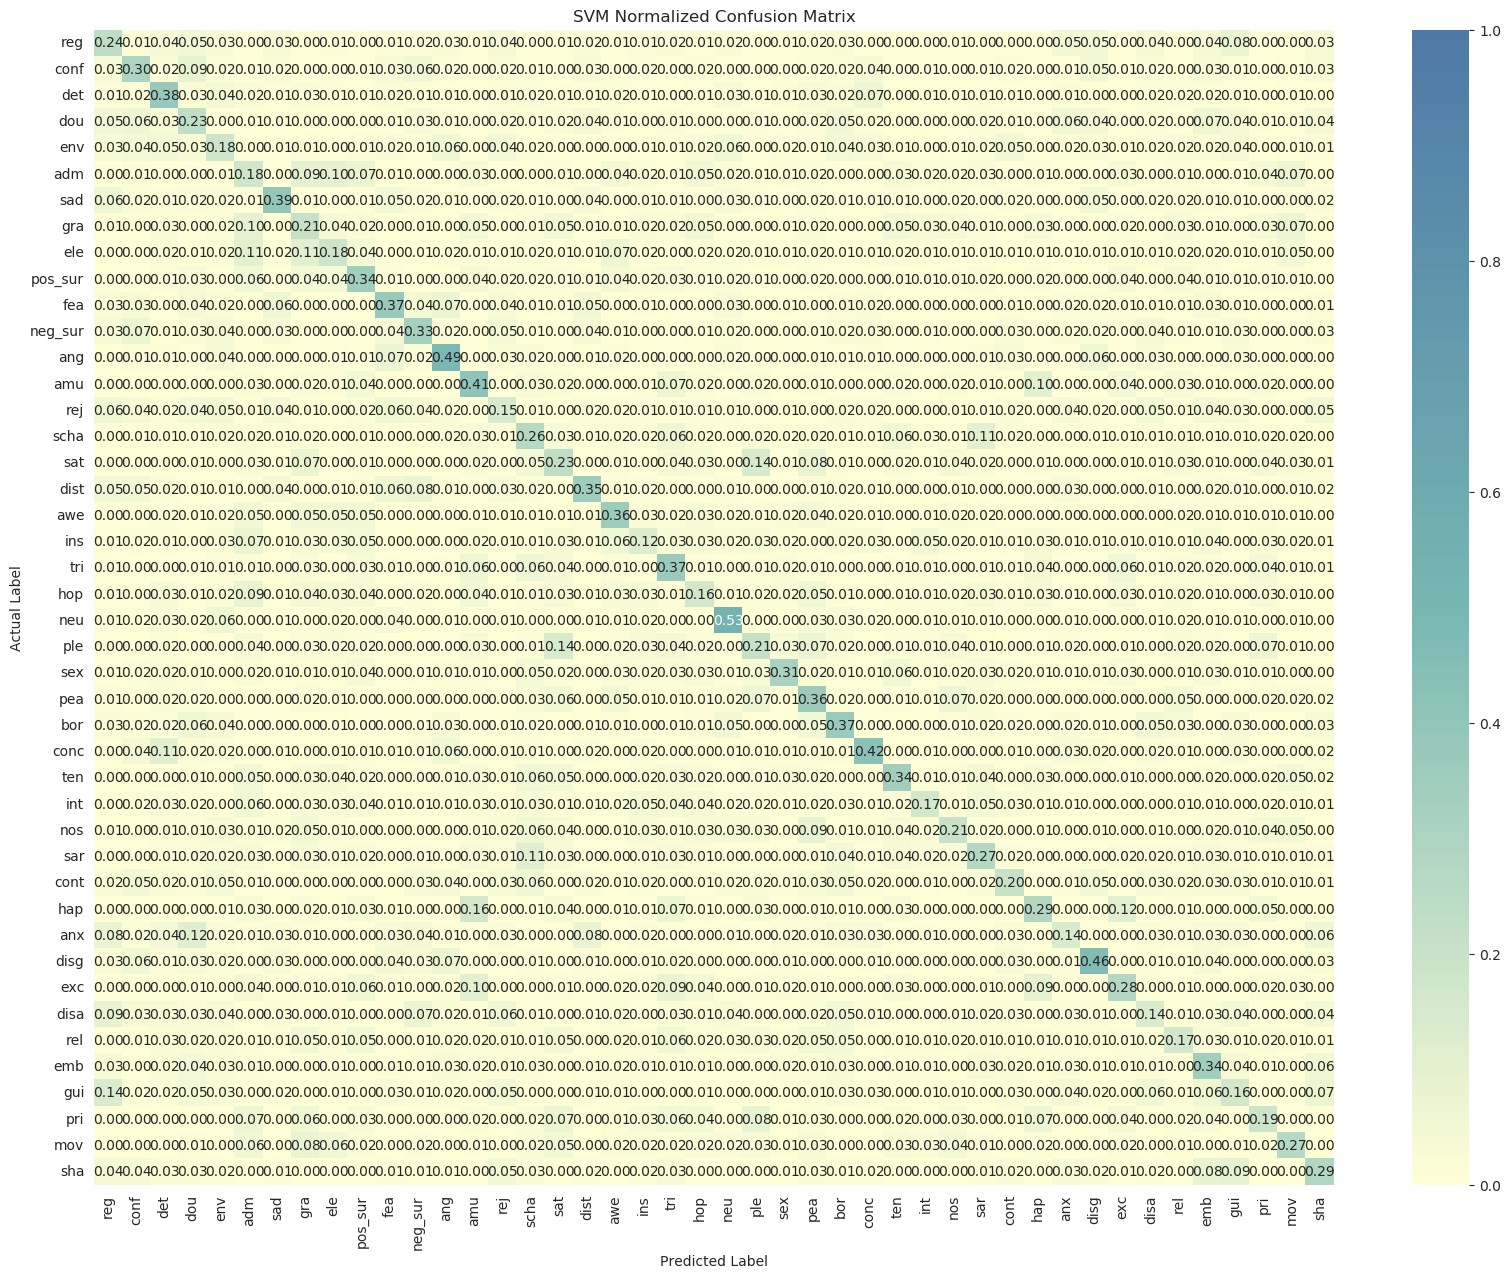

In [46]:
plot_conf_matrix(df_cm, 'SVM Normalized Confusion Matrix')

# All Modes Early Fusion

### Sorting the slices so that labels align between audio and video

In [17]:
filenames_audio = df_audio["filename"]
filenames_video = get_fixed_col(slices, "filename")

In [18]:
new_slices = [None] * len(slices)
for idx, filename_audio in enumerate(filenames_audio):
    ind = np.where(filenames_video == filename_audio)[0]
    if ind.size == 0:
        continue
    else:
        # get scalar
        ind = ind[0]
        new_slices[idx] = slices[ind]

In [19]:
new_y = get_fixed_col(new_slices, "emotion_1_id")

In [20]:
np.array_equal(y_audio, new_y)

True

## Without low level normalization

In [21]:
au_gaze_pose = get_cols(new_slices, [*AU_INTENSITY_COLS, *GAZE_COLS, *POSE_COLS])

au_gaze_pose_agg = get_aggregate_measures(au_gaze_pose,
                               means=True,
                               variance=False,
                               deltas=False,
                               peaks=False)

egemaps = df_audio[AUDIO_FUNCTIONALS_EGEMAPS_COLS].values

In [22]:
all_data = np.hstack((au_gaze_pose_agg, egemaps))

In [23]:
all_data.shape

(10006, 243)

In [24]:
scaler = MinMaxScaler()
all_data = scaler.fit_transform(all_data)

In [25]:
clf = param_search(all_data, new_y)
svc = SVC(**clf.best_params_)
evaluate_scores(all_data, new_y, svc, scoring_method="accuracy")

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 11.7min finished


{'C': 75, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.


printing accuracy measures
avg (train): 0.9993503935103029
std (train): 0.00014566989929303334
avg (validation): 0.24785060017443827
std (validation): 0.006693365379893401


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


In [28]:
skf = KFold(n_splits=5, shuffle=True)
cv = skf.split(all_data, new_y)

c = ConfusionMatrixCreator(all_data, new_y, clf.best_params_)
conf_mat = c.calculate_avg_conf_matrix(cv)

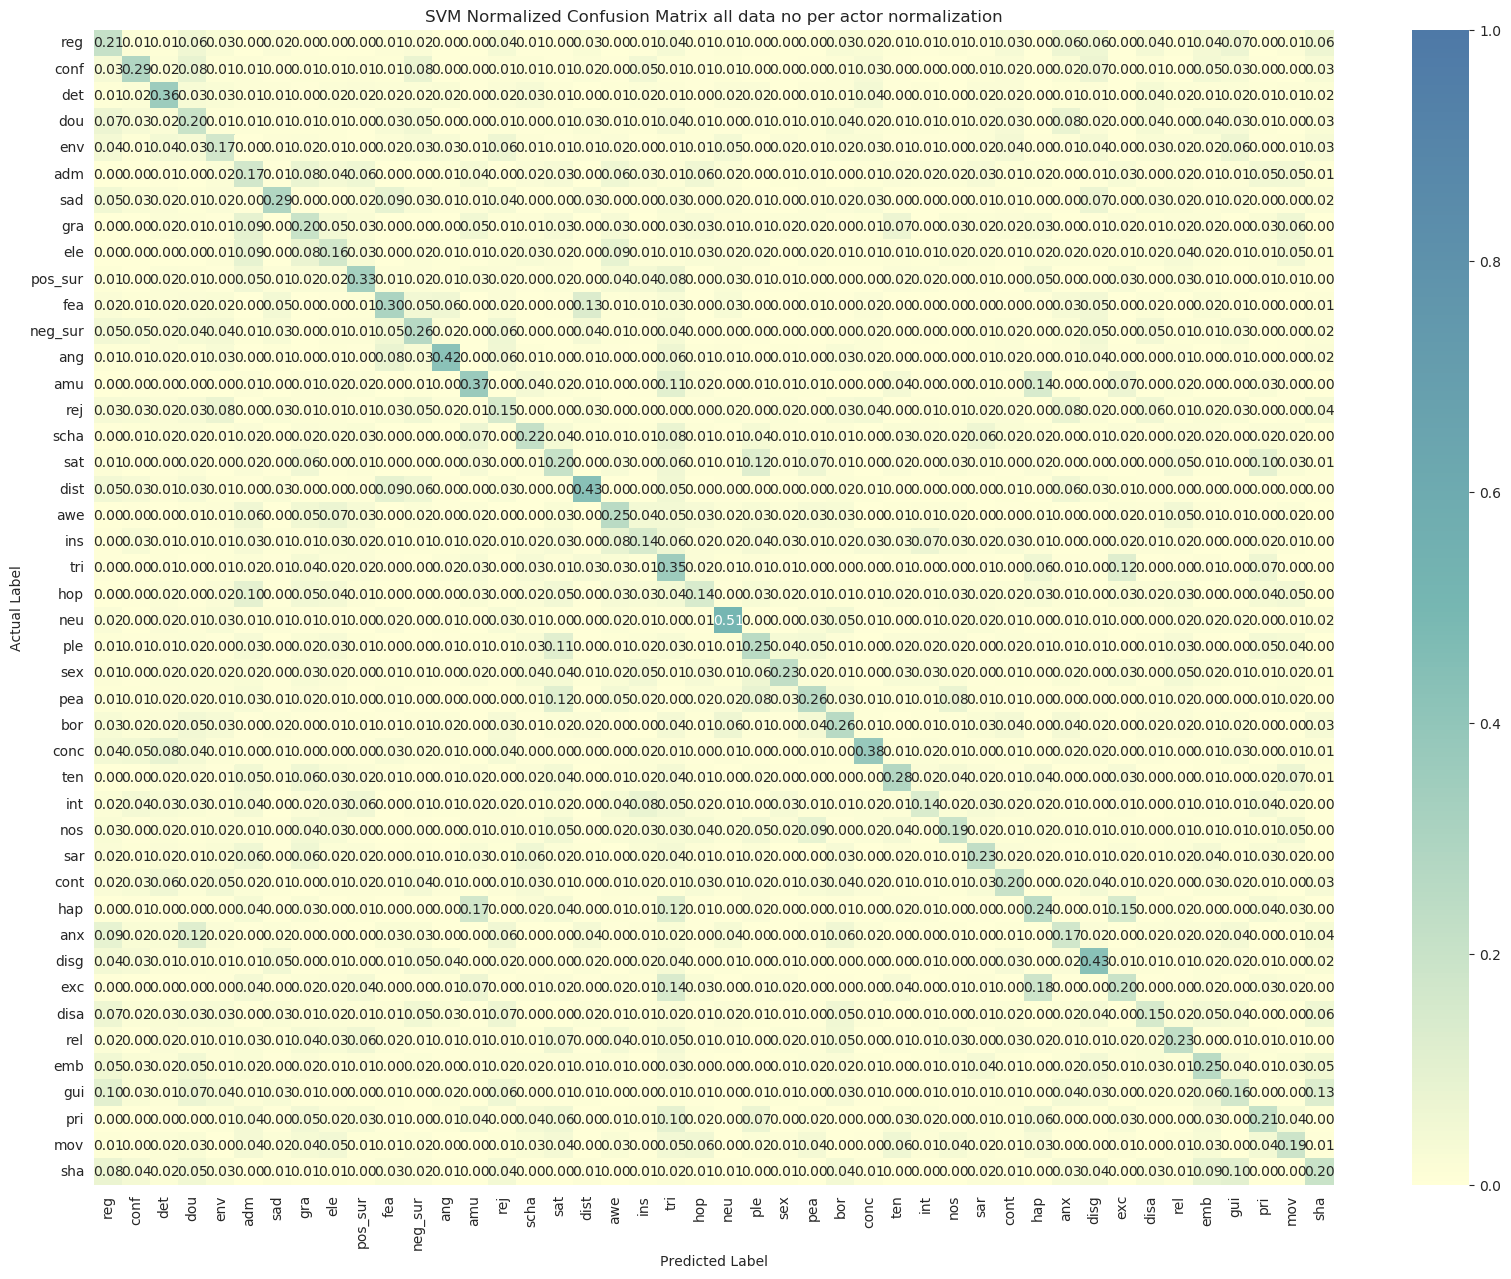

In [29]:
# get emotion_ids
emotion_ids = np.unique(new_y)

# get emotion abreviations
emotion_abrs = mapper(emotion_ids, emotion_id_to_emotion_abr)

# create dataframe with lists of emotion ids as row and column names
df_cm = pd.DataFrame(conf_mat, list(emotion_abrs), list(emotion_abrs))

plot_conf_matrix(df_cm, 'SVM Normalized Confusion Matrix all data no per actor normalization')

## With per actor low level normalization

In [39]:
au_gaze_pose = get_cols(new_slices, [*AU_INTENSITY_COLS, *GAZE_COLS, *POSE_COLS])

# scale low level
scaler = LowLevelScaler(au_gaze_pose, "standard")
scaler.scale_by_video_id(video_ids_video)
au_gaze_pose = scaler.slices

au_gaze_pose_agg = get_aggregate_measures(au_gaze_pose,
                               means=True,
                               variance=False,
                               deltas=False,
                               peaks=False)

# scale post aggregation
scaler = MinMaxScaler()
au_gaze_pose_agg = scaler.fit_transform(au_gaze_pose_agg)

# no low level scaling here since the data comes as aggregates from the beggining
egemaps = df_audio[AUDIO_FUNCTIONALS_EGEMAPS_COLS].values
egemaps = scale_by(egemaps, video_ids_audio, "min_max")

In [40]:
au_gaze_pose_agg.shape

(10006, 155)

In [41]:
egemaps.shape

(10006, 88)

In [42]:
all_data = np.hstack((au_gaze_pose_agg, egemaps))

In [43]:
all_data.shape

(10006, 243)

In [44]:
clf = param_search(all_data, new_y)
svc = SVC(**clf.best_params_)
evaluate_scores(all_data, new_y, svc, scoring_method="accuracy")

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 12.2min finished


{'C': 50, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.


printing accuracy measures
avg (train): 0.9905306903075634
std (train): 0.0005607561129013166
avg (validation): 0.28523071131766786
std (validation): 0.009509677581853067


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [45]:
skf = KFold(n_splits=5, shuffle=True)
cv = skf.split(all_data, new_y)

c = ConfusionMatrixCreator(all_data, new_y, clf.best_params_)
conf_mat = c.calculate_avg_conf_matrix(cv)

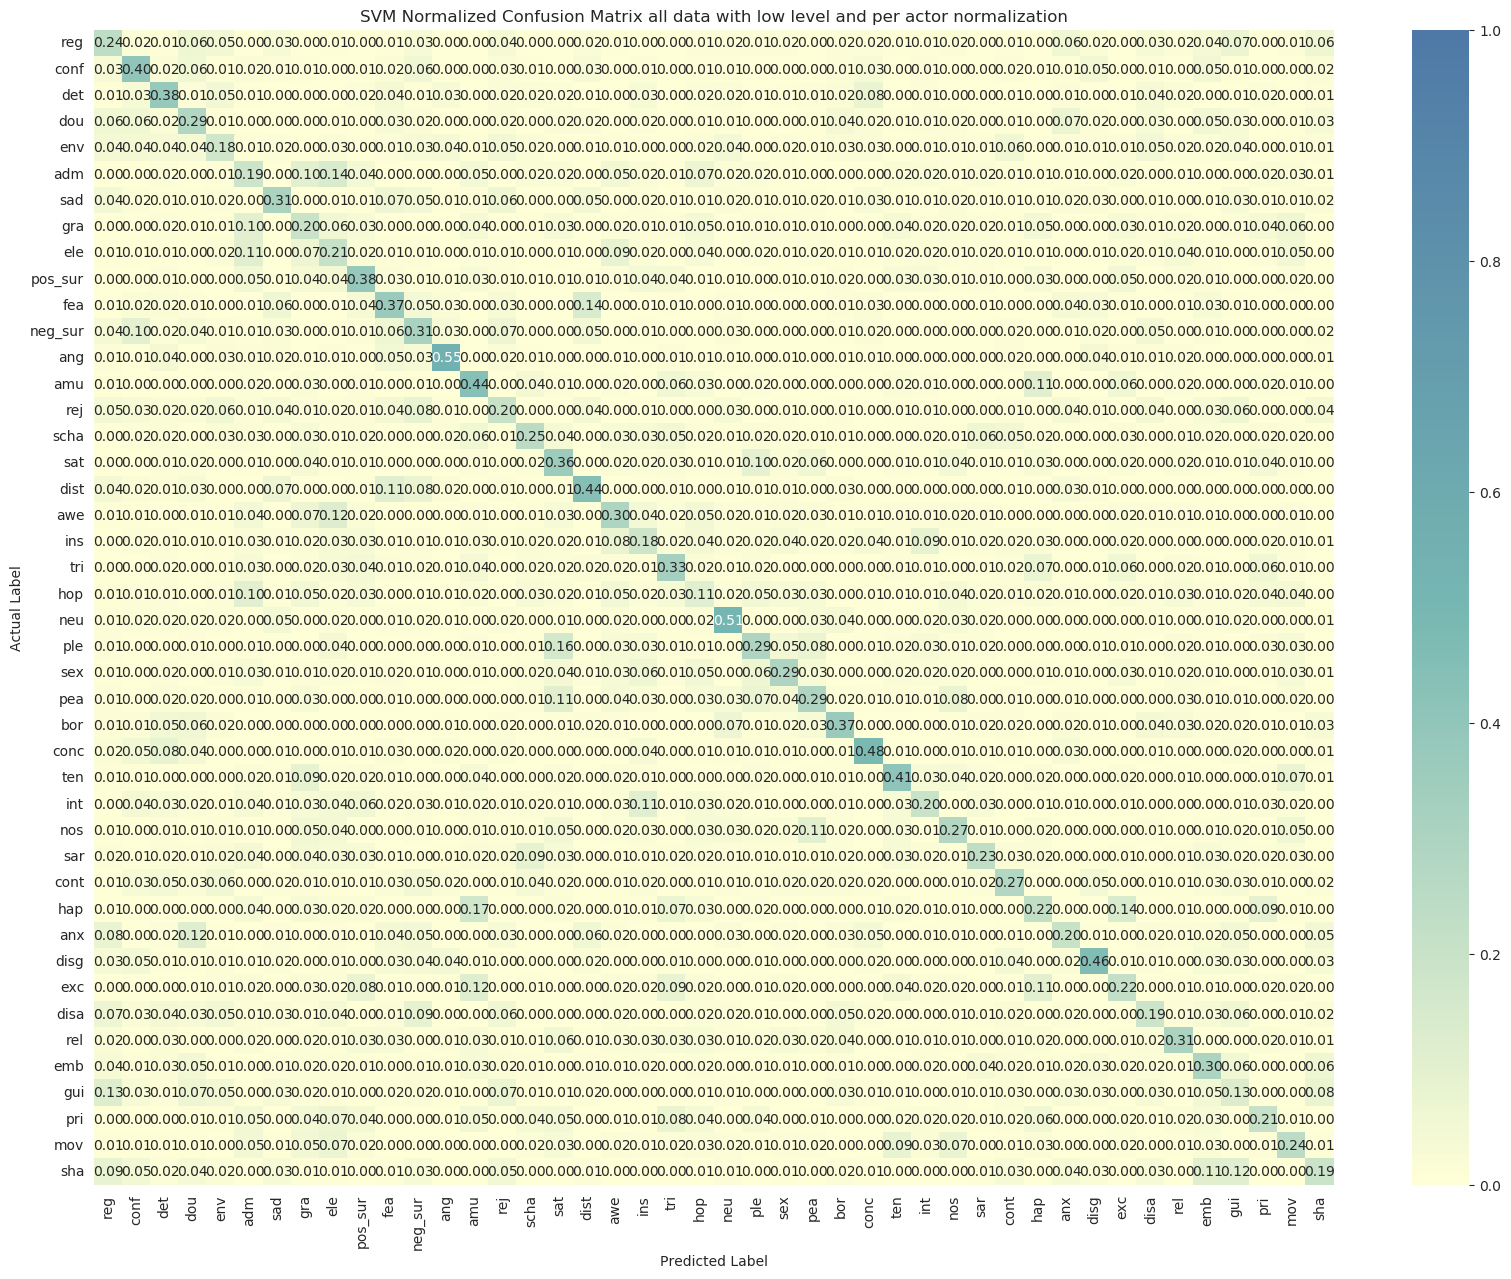

In [46]:
# get emotion_ids
emotion_ids = np.unique(new_y)

# get emotion abreviations
emotion_abrs = mapper(emotion_ids, emotion_id_to_emotion_abr)

# create dataframe with lists of emotion ids as row and column names
df_cm = pd.DataFrame(conf_mat, list(emotion_abrs), list(emotion_abrs))

plot_conf_matrix(df_cm, 'SVM Normalized Confusion Matrix all data with low level and per actor normalization')